In [ ]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import math



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
train_dir = "/content/drive/MyDrive/data/Training"
test_dir  = "/content/drive/MyDrive/data/Testing"

# Parameters
IMAGE_SIZE = 128
batch_size = 20
epochs = 5


test_paths = []
test_labels = []

# Load test paths and labels
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

print("Total test images:", len(test_paths))

# Load train paths and labels
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)


train_paths, train_labels = shuffle(train_paths, train_labels)

In [ ]:
# Visualize 10 random images
random_indices = random.sample(range(len(train_paths)), 10)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()
for i, idx in enumerate(random_indices):
    img = Image.open(train_paths[idx]).resize((IMAGE_SIZE, IMAGE_SIZE))
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Label: {train_labels[idx]}")
plt.tight_layout()
plt.show()



In [ ]:
# Augmentation function
def augment_image(image):
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    return np.array(image) / 255.0

# Open images and apply augmentation
def open_image(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img = augment_image(img)
        images.append(img)
    return np.array(images)

# Encode labels
CLASS_NAMES = sorted(os.listdir(train_dir))
def encode_label(labels):
    return np.array([CLASS_NAMES.index(label) for label in labels])

# Data generator
def datagen(paths, labels, batch_size=batch_size):
    while True:
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_images = open_image(batch_paths)
            batch_labels = encode_label(labels[i:i+batch_size])
            yield batch_images, batch_labels

In [9]:
# Build model
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False
# Unfreeze last 3 layers
for layer in base_model.layers[-4:-1]:
    layer.trainable = True

model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(CLASS_NAMES), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Train model
steps = math.ceil(len(train_paths) / batch_size)

history = model.fit(
    datagen(train_paths, train_labels, batch_size),
    steps_per_epoch=steps,
    epochs=epochs
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 1431s 5s/step - loss: 0.6536 - sparse_categorical_accuracy: 0.7330
Epoch 2/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 1417s 5s/step - loss: 0.2668 - sparse_categorical_accuracy: 0.9013
Epoch 3/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 1435s 5s/step - loss: 0.1793 - sparse_categorical_accuracy: 0.9322
Epoch 4/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 1427s 5s/step - loss: 0.1407 - sparse_categorical_accuracy: 0.9469
Epoch 5/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 1425s 5s/step - loss: 0.0907 - sparse_categorical_accuracy: 0.9668


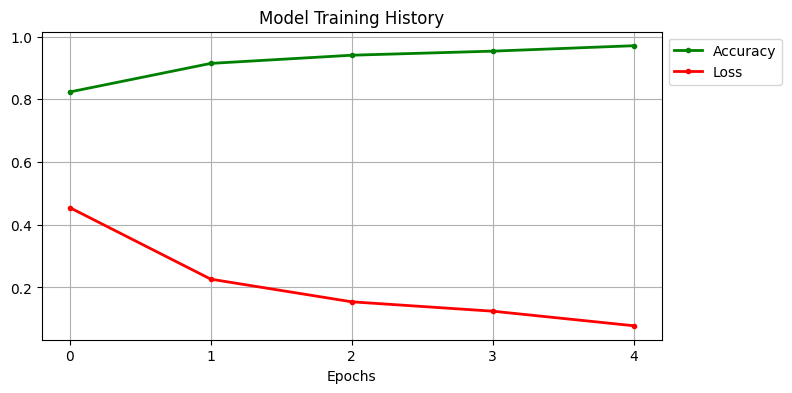

In [10]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()


In [11]:
from sklearn.metrics import confusion_matrix,classification_report,roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np

test_images = open_image(test_paths)
test_labels_encoded = encode_label(test_labels)

test_predictions = model.predict(test_images)

print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))


41/41 ━━━━━━━━━━━━━━━━━━━━ 266s 6s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.93       300
           1       0.90      0.95      0.92       306
           2       0.98      1.00      0.99       405
           3       0.98      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



Confusion Matrix:
[[266  32   1   1]
 [  4 290   6   6]
 [  0   0 405   0]
 [  0   2   2 296]]


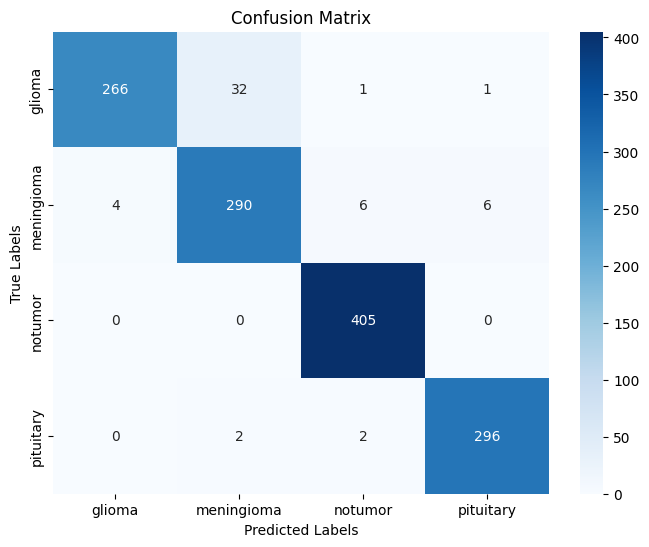

In [12]:
conf_matrix = confusion_matrix(
    test_labels_encoded,
    np.argmax(test_predictions, axis=1)
)

print("Confusion Matrix:")
print(conf_matrix)

class_names = sorted(os.listdir(train_dir))  # keep order consistent

plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [13]:
#Save the Trained Model
model.save('model.h5')

In [15]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

In [ ]:
from keras.utils import load_img, img_to_array

class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(image_path,model):
  try:
    # Load the image
    img = load_img(image_path,target_size=(128,128))
    img_array = img_to_array(img) / 255.0
    img = np.expand_dims(img_array,axis=0)

    # Prediction on the final image
    predictions = model.predict(img_array) # 0 = 0.90, 1 = 0.60, 2 = 0.99, 3 = 0.40
    predicted_class_index = np.argmax(predictions)
    confidence_score = np.max(predictions, axis=1)[0]

    # Determine the class name not just index
    if class_labels[predicted_class_index] == 'notumor':
      return "No Tumor Detected"
    else:
      return  f"Tumor {class_labels[predicted_class_index]}"

    # Display the image at last
    plt.imshow(load_img(image_path))
    plt.axis('off')
    plt.title(f"{result} (Confidence:) {confidence_score * 100:.2f}%")
    plt.show()

  except Exception as e:
    print("Error Procesing the image:", str(e))